In [ ]:
from scipy import sparse
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from tqdm import tqdm
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

sns.set(style='darkgrid')
random_state = 52

In [ ]:
train = sparse.load_npz('train.npz')

Понизим размерность входной матрицы до 10 компанент, изобразим на графике объясненную дисперсию, где мы анализируем, какой процент каждый дополнительный компонент добавляет к общей сумме. Используем SVD так как матрица разреженная.

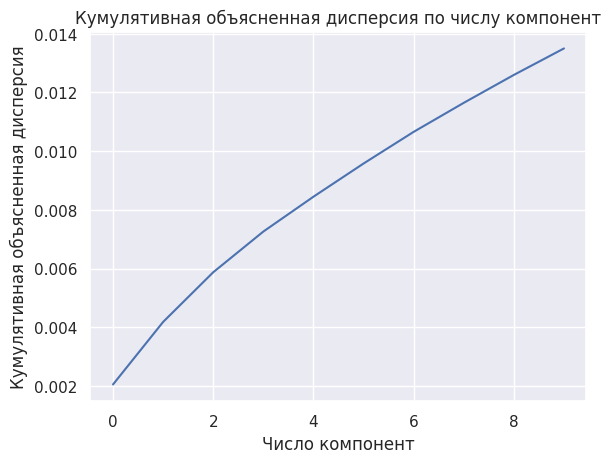

In [ ]:
svd = TruncatedSVD(n_components=10, random_state=8)

train_principal = svd.fit_transform(train)

explained_variance_ratio = svd.explained_variance_ratio_

plt.plot(np.cumsum(explained_variance_ratio[:10]))
plt.xlabel('Число компонент')
plt.ylabel('Кумулятивная объясненная дисперсия')
plt.title('Кумулятивная объясненная дисперсия по числу компонент')
plt.show()

Нормализуем данные.

In [ ]:
scaler = StandardScaler()

train_scaled = normalize(scaler.fit_transform(train_principal))
train = normalize(train)

График elbow - неплохой инструмент для принятия решения о том, сколько кластеров использовать при разделении данных. Цель состоит в том, чтобы свести к минимуму "инерцию" - показатель, который определяет расстояние между каждой точкой и центральной в процессе кластеризации.

100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


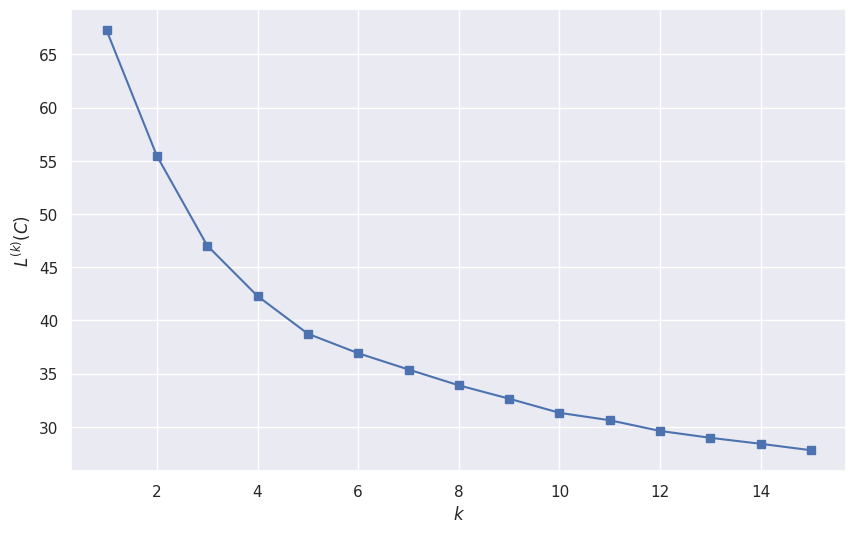

In [ ]:
def elbow(train, k_range, random_state):
    crit = []

    for k in tqdm(k_range):
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init='auto').fit(train)
        crit.append(np.sqrt(kmeans.inertia_))

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, crit, marker='s')
    plt.xlabel('$k$')
    plt.ylabel('$L^{(k)}(C)$')
    plt.show()

elbow(train_scaled[:, :3], range(1, 16), random_state)

Для этого конкретного набора данных мы видим, что после 6 кластеров "инерция" уменьшается слабо, следовательно, именно такое количество кластеров мы и выберем.

Используя реализацию sklearn различных методов кластеризации на 4 основных компонентах, выведем silhouette_score - показатель для оценки качества результатов кластеризации. Он измеряет, насколько точка данных похожа на собственный кластер по сравнению с другими кластерами. Оценка варьируется от –1 до 1, где более высокое значение указывает на лучшую производительность кластеризации. Значение, близкое к 1, предполагает, что точки данных хорошо кластеризованы и правильно разделены, а значение, близкое к -1, указывает на то, что точки данных могли быть отнесены к неправильным кластерам.

Иерархическая кластеризация.

In [ ]:
agglomerative = AgglomerativeClustering(n_clusters=6)
clusters_a = agglomerative.fit_predict(train_scaled[:, :4])

metrics.silhouette_score(train_scaled[:, :4], clusters_a)

0.22265879362628432

In [ ]:
def find_optimal_cluster_number(data, k_range):
    silhouette_average = []

    for k in tqdm(k_range):
        spectral_clustering = SpectralClustering(n_clusters=k, affinity='nearest_neighbors')
        clusters = spectral_clustering.fit_predict(data)

        silhouette_score = metrics.silhouette_score(train, clusters)
        silhouette_average.append([k, silhouette_score])

    return np.array(silhouette_average)

silhouette_average = find_optimal_cluster_number(train_principal[:, :4], range(2, 15, 1))

print(f'''n_clusters = {int(silhouette_average[np.argmax(silhouette_average[:, 1:2])][0])}
The average silhouette_score is {silhouette_average[np.argmax(silhouette_average[:, 1:2])][1]:.5f}''')

100%|██████████| 13/13 [31:33<00:00, 145.68s/it]

n_clusters = 2
The average silhouette_score is 0.00152


Две разные модели спектральной кластеризации с разными значениями параметра 'affinity'.

In [ ]:
spectral_clustering_rbf = SpectralClustering(n_clusters=6, affinity='rbf')
spectral_clustering_nn = SpectralClustering(n_clusters=6, affinity='nearest_neighbors')

clusters_rbf = spectral_clustering_rbf.fit_predict(train_scaled[:, :4])
clusters_nn = spectral_clustering_nn.fit_predict(train_scaled[:, :4])

print(metrics.silhouette_score(train_scaled[:, :4], clusters_rbf))
print(metrics.silhouette_score(train_scaled[:, :4], clusters_nn))

0.2703390560288541
0.26445085257446344


KMeans.

In [ ]:
clusters_k = KMeans(n_clusters=6, random_state=random_state, n_init='auto').fit_predict(train_scaled[:, :3])

metrics.silhouette_score(train_scaled[:, :4], clusters_k)

0.2886600303679907

Модель гауссовой смеси.

In [ ]:
clusters_g = GaussianMixture(n_components=6).fit_predict(train_scaled[:, :4])

metrics.silhouette_score(train_scaled[:, :4], clusters_g)

0.28612757181549947

In [ ]:
combined_labels = np.zeros_like(clusters_rbf)

for label in np.unique(clusters_rbf):
    hierarchical_count = np.sum(clusters_a == label)
    spectral_rbf_count = np.sum(clusters_rbf == label)
    spectral_nn_count = np.sum(clusters_nn == label)
    kmeans_count = np.sum(clusters_k == label)
    gaussian_count = np.sum(clusters_g == label)

    votes = [hierarchical_count, gaussian_count, spectral_rbf_count, spectral_nn_count, kmeans_count]
    combined_labels[(clusters_rbf == label) & (np.argmax(votes) == 1)] = label

metrics.silhouette_score(train_scaled[:, :2], combined_labels)

0.32929306813370657

Реализуем "голосование" методов.

In [ ]:
combined_labels = np.zeros_like(clusters_rbf)
for i in range(train_scaled.shape[0]):
  combined_labels[i] = Counter([clusters_a[i], clusters_rbf[i], clusters_nn[i],
                        clusters_k[i], clusters_g[i]]).most_common(1)[0][0]

metrics.silhouette_score(train_scaled[:, :4], combined_labels)

0.18772983155795595

Визуализируем кластеры на двух компанентах.

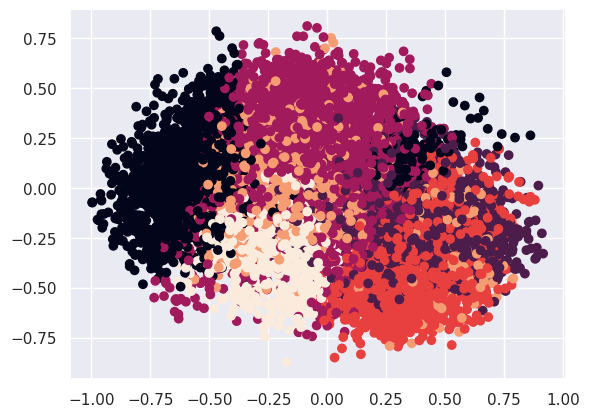

In [ ]:
plt.scatter(train_scaled[:, 0], train_scaled[:, 1],
           c = combined_labels)
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from tqdm import tqdm

def find_best_dbscan_parameters(data, eps_values, min_samples_values):
    best_score = -1
    best_params = {}
    n_clusters = 0

    for eps in tqdm(eps_values):
        for min_samples in min_samples_values:
            clusters = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(data)

            if len(set(clusters)) > 1:
                score = metrics.silhouette_score(data, clusters)

                if score > best_score:
                    best_score = score
                    best_params = {'eps': eps, 'min_samples': min_samples}
                    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

    return best_params, best_score, n_clusters

epsilon = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.]
min_samples = [5, 10, 15, 20, 25, 30, 35, 40]

best_params, best_score, n_clusters = find_best_dbscan_parameters(train_principal, epsilon, min_samples)
print('Лучшие параметры:', best_params)
print('Лучшее значение silhouette score:', best_score)
print('Количество кластеров', n_clusters)

100%|██████████| 3/3 [00:57<00:00, 19.18s/it]

Лучшие параметры: {}
Лучшее значение silhouette score: -1
Количество кластеров 0


In [ ]:
pred_df = pd.DataFrame()
pred_df['ID'] = np.arange(len(combined_labels))
pred_df['TARGET'] = combined_labels

pred_df.head()

,ID,TARGET
0,0,1
1,1,1
2,2,1
3,3,3
4,4,2


In [ ]:
pred_df.to_csv('pred.csv', index=False)

!cat pred.csv | head

ID,TARGET
0,1
1,1
2,1
3,3
4,2
5,1
6,4
7,1
8,0
